<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_4/assignment_4_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Autoencoder

# Imports

In [1]:
import numpy as np
import pickle
import requests

# other imports go here

import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from torch.utils.data import Dataset, DataLoader,TensorDataset
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from datetime import datetime

# Data loading and inspection

In [2]:
# load and inspect data
data_location = 'https://surfdrive.surf.nl/files/index.php/s/K3ArFDQJb5USQ6K/download'
data_request = requests.get(data_location)
full_data = pickle.loads(data_request.content)

In [3]:
print("len(full data): ", len(full_data))
#print("full_data: ", full_data)

len(full data):  4


In [4]:
#fmnist_classes = {0:"T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}
fmnist_classes = {0:"Trouser", 1:"Sandal", 2:"Sneaker", 3:"Bag", 4:"Ankle boot", 5:"anomaly"}

In [5]:
dt = np.dtype(np.float32)

unlabeled_data = full_data['unlabeled_data']
unlabeled_data = np.array(unlabeled_data, dtype=dt)
unlabeled_data = unlabeled_data / 255.0

labeled_data_data = full_data['labeled_data']['data']
labeled_data_data = np.array(labeled_data_data, dtype=dt)
labeled_data_data = labeled_data_data / 255.0
labeled_data_label = full_data['labeled_data']['labels']

representative_set_1_data = full_data['representative_set_1']['data']
representative_set_1_data = np.array(representative_set_1_data, dtype=dt)
representative_set_1_data = representative_set_1_data / 255.0
representative_set_1_label = full_data['representative_set_1']['labels']

representative_set_2_data = full_data['representative_set_2']['data']
representative_set_2_data = np.array(representative_set_2_data, dtype=dt)
representative_set_2_data = representative_set_2_data / 255.0
representative_set_2_label = full_data['representative_set_2']['labels']

In [6]:
## ============ anomaly sets ============ ##
anomaly_true_false_set_1 = []
for i in range(len(representative_set_1_label)):
    anomaly_true_false_set_1.append(all(representative_set_1_label[i] == [0,0,0,0,0,1]))
anomaly_index_set_1 = [i for i, x in enumerate(anomaly_true_false_set_1) if x]
anomaly_index_set_1 = anomaly_index_set_1[:50]
anomaly_representative_set_1_data = representative_set_1_data[anomaly_index_set_1]
anomaly_representative_set_1_label = representative_set_1_label[anomaly_index_set_1]

anomaly_true_false_set_2 = []
for i in range(len(representative_set_2_label)):
    anomaly_true_false_set_2.append(all(representative_set_2_label[i] == [0,0,0,0,0,1]))
anomaly_index_set_2 = [i for i, x in enumerate(anomaly_true_false_set_2) if x]
anomaly_index_set_2 = anomaly_index_set_2[:50]
anomaly_representative_set_2_data = representative_set_2_data[anomaly_index_set_2]
anomaly_representative_set_2_label = representative_set_2_label[anomaly_index_set_2]

## ============ normal sets ============ ##
normal_index_set_1 = [i for i, x in enumerate(anomaly_true_false_set_1) if not x]
normal_representative_set_1_data = representative_set_1_data[normal_index_set_1]
normal_representative_set_1_label = representative_set_1_label[normal_index_set_1]

normal_index_set_2 = [i for i, x in enumerate(anomaly_true_false_set_2) if not x]
normal_representative_set_2_data = representative_set_2_data[normal_index_set_2]
normal_representative_set_2_label = representative_set_2_label[normal_index_set_2]

In [7]:
anomaly_representative_set_data = np.concatenate((anomaly_representative_set_1_data, anomaly_representative_set_2_data))
anomaly_representative_set_label = np.concatenate((anomaly_representative_set_1_label, anomaly_representative_set_2_label))
normal_representative_set_data = np.concatenate((normal_representative_set_1_data, normal_representative_set_2_data))
normal_representative_set_label = np.concatenate((normal_representative_set_1_label, normal_representative_set_2_label))

In [8]:
#idx = 21
#print(labeled_data_label[idx])
#fig, ax = plt.subplots(1, 1, figsize=(8, 8))
#ax.imshow(labeled_data_data[idx][0], cmap="Greys")
#ax.axis('off')

(26000, 1, 32, 32)


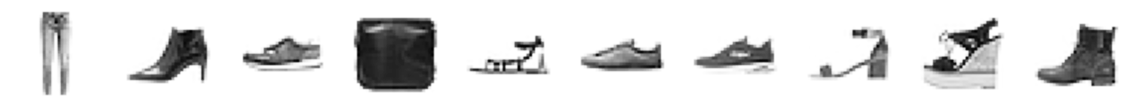

(2000, 1, 32, 32)


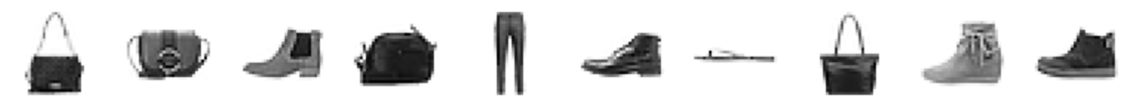

(1052, 1, 32, 32)


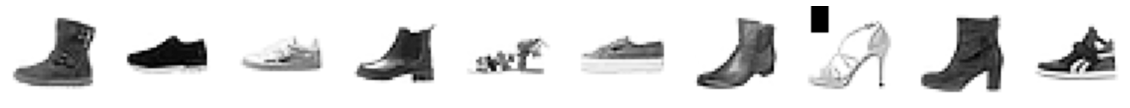

(1052, 1, 32, 32)


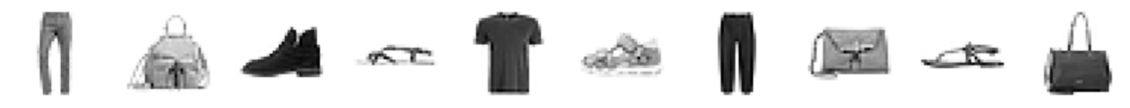

(1000, 1, 32, 32)


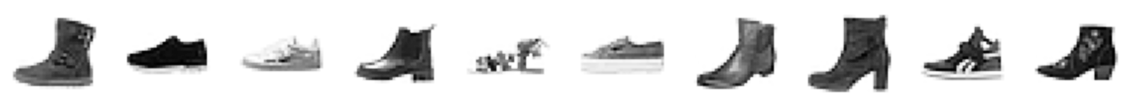

(1000, 1, 32, 32)


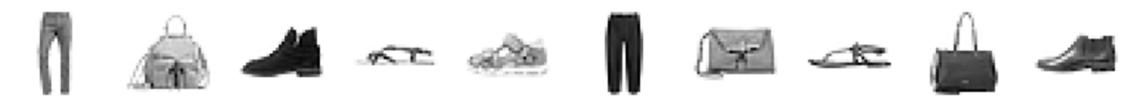

(50, 1, 32, 32)


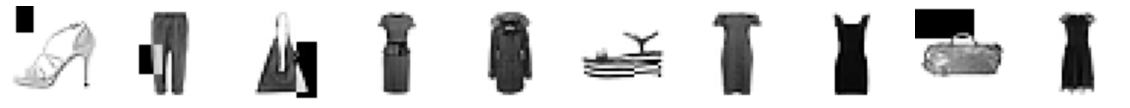

(50, 1, 32, 32)


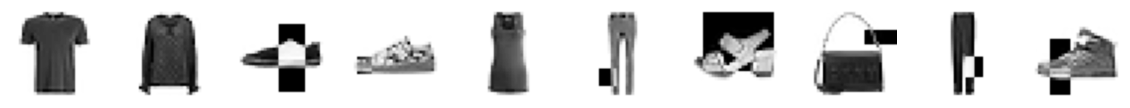

In [9]:
def show_images(x, ncols=10):
    fig, ax = plt.subplots(1, ncols, figsize=(20, 2))
    for idx in range(ncols):
        ax[idx].imshow(x[idx][0], cmap="Greys")
        ax[idx].axis('off')
    plt.show()

for i, loader in enumerate([unlabeled_data, labeled_data_data, representative_set_1_data, representative_set_2_data, normal_representative_set_1_data, normal_representative_set_2_data, anomaly_representative_set_1_data, anomaly_representative_set_2_data]):
    print(loader.shape)
    show_images(loader)

# Data preprocessing

In [10]:
# code for data preprocessing

In [11]:
def get_data_tensor(data, label):

    data_inputs = data.copy()
    
    #data_labels = np.where(label)[1]+1
    data_labels = np.where(label)[1]
    
    datas_labels = []
    for i in range(len(data_inputs)):
        datas_labels.append((data_inputs[i], data_labels[i]))

    return datas_labels

In [12]:
labeled_dataset = get_data_tensor(labeled_data_data, labeled_data_label)
set_1_dataset = get_data_tensor(representative_set_1_data, representative_set_1_label)
set_2_dataset = get_data_tensor(representative_set_2_data, representative_set_2_label)

anomaly_set_1_dataset = get_data_tensor(anomaly_representative_set_1_data, anomaly_representative_set_1_label)
anomaly_set_2_dataset = get_data_tensor(anomaly_representative_set_2_data, anomaly_representative_set_2_label)
normal_set_1_dataset = get_data_tensor(normal_representative_set_1_data, normal_representative_set_1_label)
normal_set_2_dataset = get_data_tensor(normal_representative_set_2_data, normal_representative_set_2_label)

anomaly_set_dataset = get_data_tensor(anomaly_representative_set_data, anomaly_representative_set_label)
normal_set_dataset = get_data_tensor(normal_representative_set_data, normal_representative_set_label)

In [13]:
batch_size = 50
kwargs = {'num_workers': 1, 'pin_memory': True}

# use a SubsetRandomSampler to sample only images from the normal/anomaly dataset, respectively
#anomaly_sampler_train = SubsetRandomSampler(anomaly_indices_train)

# setup DataLoaders
train_loader = DataLoader(dataset=unlabeled_data, batch_size=batch_size, **kwargs)            # for training the VAE model 

normal_loader_test = DataLoader(dataset=labeled_dataset, batch_size=batch_size, **kwargs)     # for training the VAE and NN model

normal_set_1_loader_test = DataLoader(dataset=normal_set_1_dataset, batch_size=batch_size, **kwargs)
normal_set_2_loader_test = DataLoader(dataset=normal_set_2_dataset, batch_size=batch_size, **kwargs)

anomaly_set_1_loader_test = DataLoader(dataset=anomaly_set_1_dataset, batch_size=batch_size, **kwargs)
anomaly_set_2_loader_test = DataLoader(dataset=anomaly_set_2_dataset, batch_size=batch_size, **kwargs)

normal_set_loader_test = DataLoader(dataset=normal_set_dataset, batch_size=batch_size, shuffle=False, **kwargs)          # for testing of the classifier NN model & for t-SNE plot
anomaly_set_loader_test = DataLoader(dataset=anomaly_set_dataset, batch_size=batch_size, shuffle=False, **kwargs)        # for classification

In [14]:
validation_split = .2
shuffle_dataset = True
random_seed= 42

dataset_size = len(labeled_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

normal_loader_train = DataLoader(dataset=labeled_dataset, batch_size=batch_size, sampler=train_sampler, **kwargs)            # for training the VAE model and classifier NN model
normal_loader_valid = DataLoader(dataset=labeled_dataset, batch_size=batch_size, sampler=valid_sampler, **kwargs)            # for validation of the classifier NN model

# Model definitions

In [1]:
# code for model definitions

In [16]:
class EncoderClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.encConv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=4, padding=0)
        self.conv1_bn=nn.BatchNorm2d(8)
        self.encConv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=4, padding=0)
        self.conv2_bn=nn.BatchNorm2d(16)
        self.encConv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, padding=0)
        self.conv3_bn=nn.BatchNorm2d(32)
        self.maxPool = nn.MaxPool2d(kernel_size=4, stride=1, return_indices=True)
#        self.fc_input = nn.Linear(32*23*23, hidden_dim)
        self.fc_input = nn.Linear(32*20*20, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_sigma = nn.Linear(hidden_dim, latent_dim)
        self.fc_classifier = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x):
        x = torch.relu(self.encConv1(x))
        en_max1_input_size = x.size()
        x, indices01 = self.maxPool(x)
        x = torch.relu(self.encConv2(x))
        x, indices02 = self.maxPool(x)
        x = torch.relu(self.encConv3(x))
        batch, _, _, _ = x.shape
        x = x.reshape(batch, -1)
        h = torch.relu(self.fc_input(x))
        mu = self.fc_mu(h)
        log_sigma = self.fc_sigma(h)
        classification = self.fc_classifier(h)
        z = self.reparameterization(mu, log_sigma)

        return z, mu, log_sigma, classification, indices01, indices02, en_max1_input_size
    
    def reparameterization(self, mu, log_sigma):
        sigma = torch.exp(log_sigma)
        epsilon = torch.rand_like(sigma).to(DEVICE)
        z = mu + sigma * epsilon
        
        return z

class DecoderClassifier(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
#        self.fc_output = nn.Linear(latent_dim, 32*23*23)
        self.fc_output = nn.Linear(latent_dim, 32*20*20)
        self.decConv1 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=1, padding=0)
        self.conv1_bn=nn.BatchNorm2d(32)
        self.decConv2 = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=4, stride=1, padding=0)
        self.conv2_bn=nn.BatchNorm2d(16)
        self.decConv3 = nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=4, stride=1, padding=0)
        self.conv3_bn=nn.BatchNorm2d(8)
        self.maxUnpool = nn.MaxUnpool2d(kernel_size=4, stride=1)
        
    def forward(self, x, indices01, indices02, en_max1_input_size):
        h = torch.relu(self.fc_output(x))
#        h = h.view(-1, 32, 23, 23)
        h = h.view(-1, 32, 20, 20)
        h = torch.relu(self.decConv1(h))
        h = self.maxUnpool(h, indices02, en_max1_input_size)
        h = torch.relu(self.decConv2(h))
        h = self.maxUnpool(h, indices01, en_max1_input_size)
        x_reconstr = torch.sigmoid(self.decConv3(h))
        return x_reconstr

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.encConv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=4, padding=0)
        self.conv1_bn=nn.BatchNorm2d(8)
        self.encConv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=4, padding=0)
        self.conv2_bn=nn.BatchNorm2d(16)
        self.encConv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, padding=0)
        self.conv3_bn=nn.BatchNorm2d(32)
        self.fc_input = nn.Linear(32*23*23, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_sigma = nn.Linear(hidden_dim, latent_dim)
        self.fc_classifier = nn.Linear(hidden_dim, latent_dim)
        self.maxPool = nn.MaxPool2d(kernel_size=4, stride=1, return_indices=True)
        
    def forward(self, x):
        x = torch.relu(self.encConv1(x))
        x = torch.relu(self.encConv2(x))
        x = torch.relu(self.encConv3(x))
        batch, _, _, _ = x.shape
        x = x.reshape(batch, -1)
        h = torch.relu(self.fc_input(x))
        mu = self.fc_mu(h)
        log_sigma = self.fc_sigma(h)
        classification = self.fc_classifier(h)
        z = self.reparameterization(mu, log_sigma)

        return z, mu, log_sigma, classification
    
    def reparameterization(self, mu, log_sigma):
        sigma = torch.exp(log_sigma)
        epsilon = torch.rand_like(sigma).to(DEVICE)
        z = mu + sigma * epsilon
        
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_output = nn.Linear(latent_dim, 32*23*23)
        self.decConv1 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=1, padding=0)
        self.conv1_bn=nn.BatchNorm2d(32)
        self.decConv2 = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=4, stride=1, padding=0)
        self.conv2_bn=nn.BatchNorm2d(16)
        self.decConv3 = nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=4, stride=1, padding=0)
        self.conv3_bn=nn.BatchNorm2d(8)
        self.maxUnpool = nn.MaxUnpool2d(kernel_size=4, stride=1)
        
    def forward(self, x):
        h = torch.relu(self.fc_output(x))
        h = h.view(-1, 32, 23, 23)
        h = torch.relu(self.decConv1(h))
        h = torch.relu(self.decConv2(h))
        x_reconstr = torch.sigmoid(self.decConv3(h))
        return x_reconstr

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(10, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64,5)
        self.dropout = nn.Dropout(0.25)
        self.fc1_bn=nn.BatchNorm1d(256)
        self.fc2_bn=nn.BatchNorm1d(64)
        
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc1_bn(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc2_bn(x))
        x = self.fc3(x)
        return x

class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
                
    def forward(self, x):
        z, mu, log_sigma = self.encoder(x)
        x_reconstr = self.decoder(z)
        
        return x_reconstr, mu, log_sigma

class VAEClassifier(nn.Module):
    def __init__(self, encoder, decoder, classifier):
        super(VAEClassifier, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.classifier = classifier
    
    def forward(self, x):
        z, mu, log_sigma, classification = self.encoder(x)
        x_reconstr = self.decoder(z)
        y_preds = self.classifier(classification)
        
        return x_reconstr, mu, log_sigma, y_preds
        

x_dim  = 1024            # 32*32
hidden_dim = 500
latent_dim = 10

cuda = True  # NOTE: if running in Google Colab, make sure to go to "Edit > Notebook settings" and set "Hardware accelerator" to "GPU"
DEVICE = torch.device("cuda" if cuda else "cpu")
print(DEVICE)

encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim)

classifier = Classifier()

vae = VAE(encoder=encoder, decoder=decoder).to(DEVICE)
vaeclassifier = VAEClassifier(encoder=encoder, decoder=decoder, classifier=classifier).to(DEVICE)

lr = 1e-3

def loss_function(x, x_reconstr, mu, log_sigma):
    reconstr_loss = nn.functional.mse_loss(x_reconstr, x, reduction='sum')
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1)
    total_loss = reconstr_loss + kl_loss
    return total_loss, reconstr_loss, kl_loss

#optimizer = Adam(vae.parameters(), lr=lr)                                     
optimizer = Adam(vaeclassifier.parameters(), lr=lr)

cuda


# Training and validation loop

In [18]:
# perform training

In [19]:
n_epochs = 50

print("Start training VAE...")
#vae.train()

train_losses = []
valid_losses = []

for epoch in range(n_epochs):
    train_overall_loss = 0
    train_overall_reconstr_loss = 0
    train_overall_kl_loss = 0
    train_overall_classification_loss = 0
    valid_overall_loss = 0
    valid_overall_reconstr_loss = 0
    valid_overall_kl_loss = 0
    valid_overall_classification_loss = 0
    
    for batch_idx_01, x in enumerate(train_loader):
        vaeclassifier.train()
        #x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_reconstr, mu, log_sigma, y_preds = vaeclassifier(x)
        loss, reconstr_loss, kl_loss = loss_function(x, x_reconstr, mu, log_sigma)
        
        train_overall_loss += loss.item()
        train_overall_reconstr_loss += reconstr_loss.item()
        train_overall_kl_loss += kl_loss.item()
        
        loss.backward()
        optimizer.step()
    
    for batch_idx_02a, (x, y) in enumerate(normal_loader_train):
        vaeclassifier.train()
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        optimizer.zero_grad()
        
        x_reconstr, mu, log_sigma, y_preds = vaeclassifier(x)
        loss_vae, reconstr_loss, kl_loss = loss_function(x, x_reconstr, mu, log_sigma)
        train_loss_classification = F.cross_entropy(y_preds, y) # compute loss
        
        loss = loss_vae.add_(train_loss_classification)
    
        train_overall_loss += loss.item()
        train_overall_reconstr_loss += reconstr_loss.item()
        train_overall_kl_loss += kl_loss.item()
        
        train_overall_classification_loss += train_loss_classification.item()
        
        loss.backward()
        optimizer.step()
    
    for batch_idx_02b, (x, y) in enumerate(normal_loader_valid):
        vaeclassifier.eval()
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        x_reconstr, mu, log_sigma, y_preds = vaeclassifier(x)
        loss_vae, reconstr_loss, kl_loss = loss_function(x, x_reconstr, mu, log_sigma)
        valid_loss_classification = F.cross_entropy(y_preds, y) # compute loss
        
        loss = loss_vae.add_(valid_loss_classification)
        
        valid_overall_loss += loss.item()
        valid_overall_reconstr_loss += reconstr_loss.item()
        valid_overall_kl_loss += kl_loss.item()
        
        valid_overall_classification_loss += valid_loss_classification.item()
        
    
#    n_datapoints = batch_idx * batch_size
    train_n_datapoints = (batch_idx_01 + batch_idx_02a) * batch_size

    
    train_average_loss = train_overall_loss / train_n_datapoints
    train_reconstruction_loss = train_overall_reconstr_loss / train_n_datapoints
    train_KL_loss = train_overall_kl_loss / train_n_datapoints
    train_classification_loss = train_overall_classification_loss / (batch_idx_02a * batch_size)
    
    valid_average_loss = valid_overall_loss / (batch_idx_02b * batch_size)
    valid_reconstruction_loss = valid_overall_reconstr_loss / (batch_idx_02b * batch_size)
    valid_KL_loss = valid_overall_kl_loss / (batch_idx_02b * batch_size)
    valid_classification_loss = valid_overall_classification_loss / (batch_idx_02b * batch_size)
    
    train_losses.append(train_average_loss)
    valid_losses.append(valid_average_loss)
    
    print("Epoch {} \t TRAIN LOSS: average {:.4f}   reconst {:.4f}   KL {:.4f}   class {:.4f} \t VALID LOSS: average {:.4f}   reconst {:.4f}   KL {:.4f}   class {:.4f}".format(epoch+1, train_average_loss, train_reconstruction_loss, train_KL_loss, train_classification_loss, valid_average_loss, valid_reconstruction_loss, valid_KL_loss, valid_classification_loss))
    #print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss / n_datapoints, "\tReconstruction Loss:", overall_reconstr_loss / n_datapoints, "\tKL Loss:", overall_kl_loss / n_datapoints)
    
print("Training complete!")

Start training VAE...
Epoch 1 	 TRAIN LOSS: average 42.2939   reconst 39.6647   KL 2.6282   class 0.0180 	 VALID LOSS: average 22.8968   reconst 19.6996   KL 3.1824   class 0.0148
Epoch 2 	 TRAIN LOSS: average 19.4527   reconst 16.4468   KL 3.0055   class 0.0086 	 VALID LOSS: average 20.8695   reconst 17.2864   KL 3.5750   class 0.0081
Epoch 3 	 TRAIN LOSS: average 18.2000   reconst 15.0644   KL 3.1352   class 0.0059 	 VALID LOSS: average 20.5577   reconst 17.1560   KL 3.3961   class 0.0056
Epoch 4 	 TRAIN LOSS: average 17.5892   reconst 14.3951   KL 3.1938   class 0.0055 	 VALID LOSS: average 19.5951   reconst 15.9645   KL 3.6245   class 0.0061
Epoch 5 	 TRAIN LOSS: average 17.1662   reconst 13.9318   KL 3.2342   class 0.0045 	 VALID LOSS: average 19.1220   reconst 15.5767   KL 3.5397   class 0.0056
Epoch 6 	 TRAIN LOSS: average 16.9343   reconst 13.6785   KL 3.2555   class 0.0046 	 VALID LOSS: average 19.1010   reconst 15.5744   KL 3.5211   class 0.0055
Epoch 7 	 TRAIN LOSS: average 

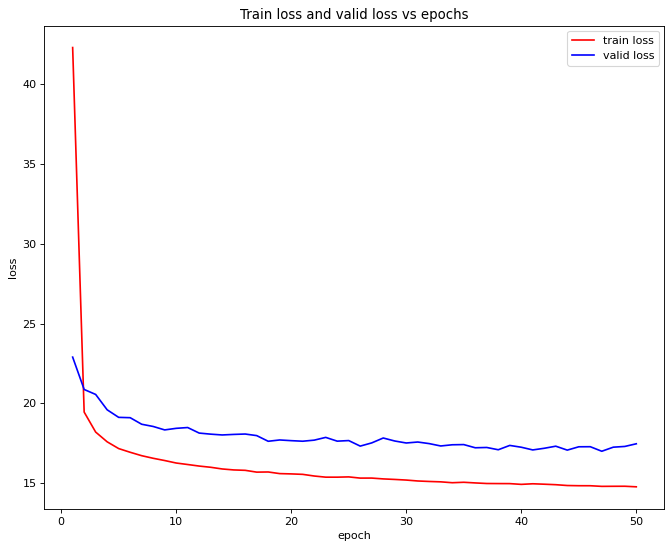

In [20]:
## Training loss and valid loss vs epochs plot

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(10, 8), dpi=80)

epochs_range = np.arange(1,n_epochs+1)

# plotting
plt.title("Train loss and valid loss vs epochs")
plt.xlabel("epoch")
plt.ylabel("loss")

plt.plot(epochs_range, train_losses, color ="red")
plt.plot(epochs_range, valid_losses, color ="blue")
plt.legend(['train loss', 'valid loss'], loc='best')
plt.show()

# Inspection, Validation, and Analysis

In [21]:
# Inspect, validate, and analyse your trained model

In [22]:
def elbo_elementwise(x, x_reconstr, mu, log_sigma):
    x = x.view(batch_size, x_dim)
    x_reconstr = x_reconstr.view(batch_size, x_dim)
    
    reconstr_loss = torch.sum(nn.functional.mse_loss(x_reconstr, x, reduction='none'), dim=1)
    constant_term = x_dim * 0.5 * np.log(np.pi)  # assuming sigma=1/sqrt(2)
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1, dim=1)
    elbo = - reconstr_loss - constant_term - kl_loss
    return elbo, reconstr_loss, kl_loss

In [23]:
vaeclassifier.eval()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

x_original_list_normal = []
x_reconstr_list_normal = []
y_label_normal = []
elbos_normal = []
x_original_list_anomaly = []
x_reconstr_list_anomaly = []
y_label_anomaly = []
elbos_anomaly = []

mu_list = []
y_list = []
y_preds_list = []

y_list_anomaly = []

all_preds = torch.tensor([]).to(device)
all_preds_anomaly = torch.tensor([]).to(device)
x_anomaly = torch.tensor([]).to(device)

with torch.no_grad():
    for batch_idx, (x, y) in enumerate(tqdm(normal_set_loader_test)):
#        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        
#        x_reconstr, mu, log_sigma = vae(x)
        x_reconstr, mu, log_sigma, y_preds = vaeclassifier(x)
        elbo, reconstr_loss, kl_loss = elbo_elementwise(x, x_reconstr, mu, log_sigma)

        y_label_normal.append(y)
        x_original_list_normal.append(x)
        x_reconstr_list_normal.append(x_reconstr)
        elbos_normal.append(elbo.cpu().numpy())
        
        y_list.append(y)
        mu_list.append(mu.cpu().numpy())
        y_preds_list.append(y_preds)
        
        all_preds = torch.cat((all_preds, y_preds), dim=0) # join along existing axis
        
    
    for batch_idx, (x, y) in enumerate(tqdm(anomaly_set_loader_test)):
#        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        
#        x_reconstr, mu, log_sigma = vae(x)
        x_reconstr, mu, log_sigma, y_preds = vaeclassifier(x)
        elbo, reconstr_loss, kl_loss = elbo_elementwise(x, x_reconstr, mu, log_sigma)

        y_label_anomaly.append(y)
        x_original_list_anomaly.append(x)
        x_reconstr_list_anomaly.append(x_reconstr)
        elbos_anomaly.append(elbo.cpu().numpy())
        
        y_list_anomaly.append(y)
        
        x_anomaly = torch.cat((x_anomaly, x), dim=0) # join along existing axis
        all_preds_anomaly = torch.cat((all_preds_anomaly, y_preds), dim=0) # join along existing axis

elbos_normal = np.concatenate(elbos_normal)  # loss values represent *negative* ELBO values
elbos_anomaly = np.concatenate(elbos_anomaly)

y_list = np.concatenate(y_list)
y_pred = all_preds.argmax(1).cpu().numpy()

y_list_anomaly = np.concatenate(y_list_anomaly)
y_pred_anomaly = all_preds_anomaly.argmax(1).cpu().numpy()

mu_list = np.concatenate(mu_list)

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 22.64it/s]


## Accuracy

Accuracy:  0.955

Correct Predictions


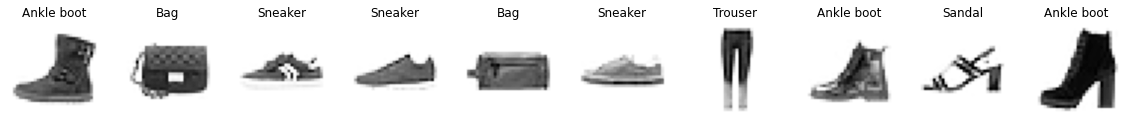


Wrong Predictions


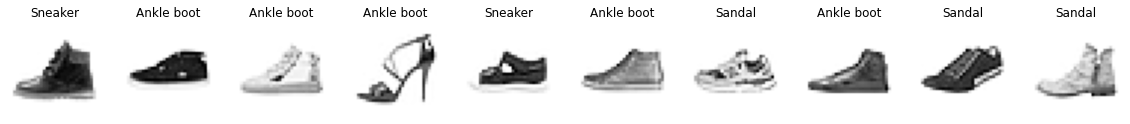

In [24]:
list_comparison = y_list == y_pred
true_indeces = [i for i, x in enumerate(list_comparison) if x]
false_indeces = [i for i, x in enumerate(list_comparison) if not x]

accuracy = np.sum(y_list == y_pred) / len(y_list)
print("Accuracy: ", accuracy)

normal_set_correct_prediction_data = normal_representative_set_data[true_indeces]
normal_set_correct_prediction_label = y_pred[true_indeces]
#normal_set_correct_prediction_label = np.where(normal_representative_set_label[true_indeces])[1]
normal_set_wrong_prediction_data = normal_representative_set_data[false_indeces]
normal_set_wrong_prediction_label = y_pred[false_indeces]

print()

print("Correct Predictions")
fig, ax = plt.subplots(1, 10, figsize=(20, 2))
for idx in range(10):
    ax[idx].imshow(normal_set_correct_prediction_data[idx*10][0], cmap="Greys")
    ax[idx].set_title(fmnist_classes[normal_set_correct_prediction_label[idx*10]])
    ax[idx].axis('off')
plt.show()

print()

print("Wrong Predictions")
fig, ax = plt.subplots(1, 10, figsize=(20, 2))
for idx in range(10):
    ax[idx].imshow(normal_set_wrong_prediction_data[idx+12][0], cmap="Greys")
    ax[idx].set_title(fmnist_classes[normal_set_wrong_prediction_label[idx+12]])
    ax[idx].axis('off')
plt.show()

In [25]:
def show_images_output(x, y, ncols=10):
    """ plots first ncols images in a batch """
    x = x.view(batch_size, 32, 32)

    fig, ax = plt.subplots(1, ncols, figsize=(20, 2))
    for idx in range(ncols):
        ax[idx].imshow(x[idx].cpu().numpy(), cmap="Greys")
        ax[idx].axis('off')
        ax[idx].set_title(fmnist_classes[y[idx].item()])
    plt.show()

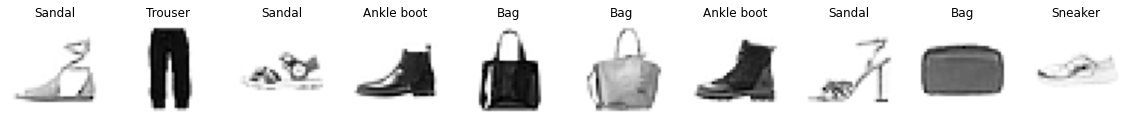

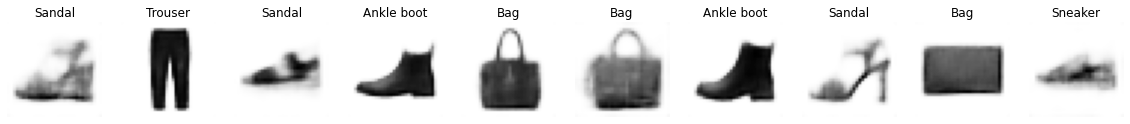

In [26]:
batch_idx = 10
show_images_output(x_original_list_normal[batch_idx], y_label_normal[batch_idx])
show_images_output(x_reconstr_list_normal[batch_idx], y_label_normal[batch_idx])

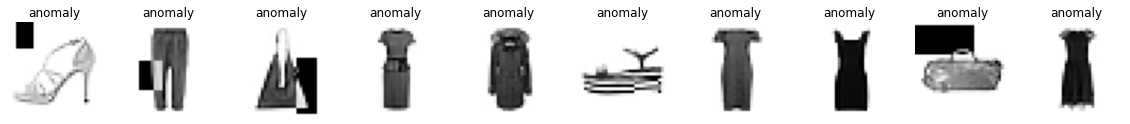

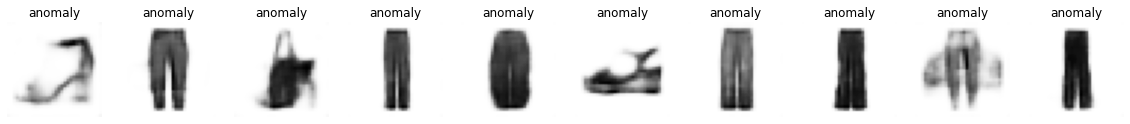

In [27]:
batch_idx = 0
show_images_output(x_original_list_anomaly[batch_idx], y_label_anomaly[batch_idx])
show_images_output(x_reconstr_list_anomaly[batch_idx], y_label_anomaly[batch_idx])

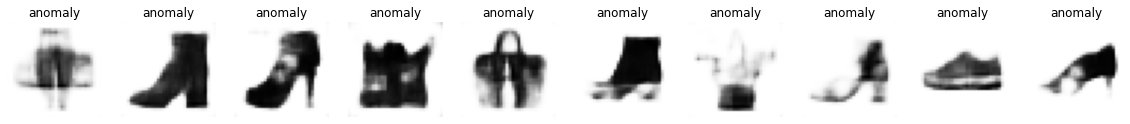

In [28]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)

show_images_output(generated_images, y_label_anomaly[batch_idx])

# Anomaly Detection: density plots

We now have two sets of ELBO (= approximate likelihood) scores, one for normal test data and one for anomalous test data. Ideally, we'd want all anomalous data points to have a lower likelihood than all normal data, but this is hard to achieve in practice. Let's first visually inspect how well we did.

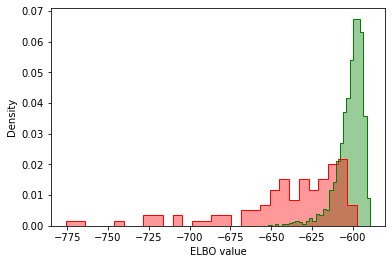

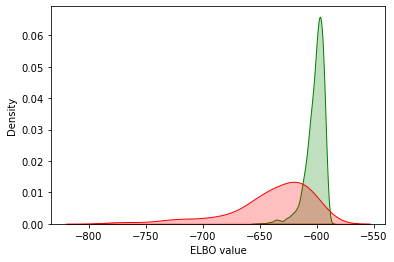

In [29]:
def density_histogram(neg, pos, bins=30, alpha=0.4):
    plt.figure()
    plt.hist(neg, bins=bins, density=True, histtype="bar", color="g", alpha=alpha)
    plt.hist(neg, bins=bins, density=True, histtype="step", color="g", alpha=1)
    plt.hist(pos, bins=bins, density=True, histtype="bar", color="r", alpha=alpha)
    plt.hist(pos, bins=bins, density=True, histtype="step", color="r", alpha=1)
    plt.xlabel("ELBO value")
    plt.ylabel("Density")
    plt.show()


def density_plot(neg, pos):
    plt.figure()
    sns.kdeplot(neg, shade=True, color="g")
    sns.kdeplot(pos, shade=True, color="r")
    plt.xlabel("ELBO value")
    plt.ylabel("Density")

density_histogram(elbos_normal, elbos_anomaly)
density_plot(elbos_normal, elbos_anomaly)

# Anomaly Detection: ROC/PR curves

Given the ELBO (= approximate likelihood) scores, we can choose a threshold and classify all instances with a likelihood below the threshold as anomalies, and all instances with a likelihood above the threshold as "normal". Different thresholds will give different True/False Positive/Negative scores. We can summarise the performance of all possible thresholds in an ROC curve, or a Precision-Recall curve (the latter has been shown to be more suitable for imbalanced datasets, see https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4349800/). In particular, the area under a ROC or Precision-Recall curve can be used as a quantitative measure to evaluate anomaly detection.

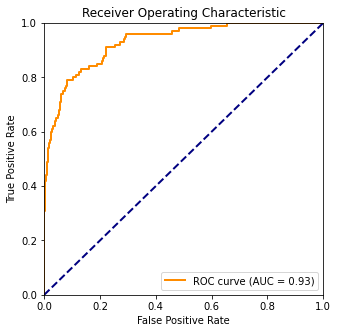

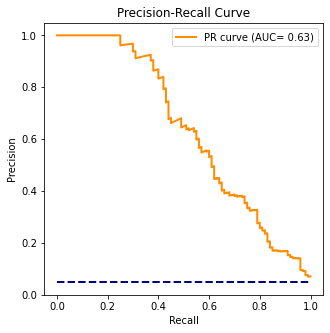

In [30]:
def roc_pr_curves(neg, pos):
    # translate to scores from 0 to 1, where 1 means anomaly (low ELBO) and 0 means normal (high ELBO)
    min_val = min(np.min(neg), np.min(pos))
    max_val = max(np.max(neg), np.max(pos))
    y_true_neg = np.zeros(neg.shape)
    y_true_pos = np.ones(pos.shape)
    y_true = np.concatenate((y_true_neg, y_true_pos))
    y_score = (max_val - np.concatenate((neg, pos))) / (max_val - min_val)

    # get ROC curve values
    fpr, tpr, _ = roc_curve(y_true, y_score, drop_intermediate=True)
    auroc = auc(fpr, tpr)

    # plot ROC curve
    lw = 2
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % auroc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    # get Precision-Recall values
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    auprc = auc(recall, precision)

    # plot Precision-Recall curve
    no_skill = len(y_true[y_true==1]) / len(y_true)
    plt.figure(figsize=(5, 5))
    plt.plot([0, 1], [no_skill, no_skill], color="navy", lw=lw, linestyle='--')
    plt.plot(recall, precision, color='darkorange',
             lw=lw, label="PR curve (AUC= %0.2f)" % auprc)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("Precision-Recall Curve")
    plt.legend(loc="upper right")
    plt.show()

roc_pr_curves(elbos_normal, elbos_anomaly)

In [31]:
threshold = -612.0

acc = (sum(elbos_normal>threshold) + sum(elbos_anomaly<threshold))/2104*100
print("acc = %.2f%%" % (acc))

acc = 89.92%


# t-SNE

In [32]:
from sklearn.manifold import TSNE

mu_list = torch.Tensor(mu_list)
mu_list = mu_list.detach().cpu().numpy()
#mu_array = np.array(mu_list)

d2_embs = TSNE(n_components=2, perplexity=200, learning_rate="auto", n_iter=10000, random_state=2).fit_transform(mu_list)

/home/ctw/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
import seaborn as sns
import pandas as pd

# fmnist_classes = {0:"Trouser", 1:"Sandal", 2:"Sneaker", 3:"Bag", 4:"Ankle boot", 5:"anomaly"}

def plot_tsne(tsne_embeds, labels):
    #pass
    fig = plt.gcf()
    fig.set_size_inches(13, 13)
    
    rps = [];
    for i in range(len(labels)):
        rps.append(fmnist_classes[labels[i]])
    rps = pd.DataFrame(rps)
    rps.rename(columns={0:'type'}, inplace=True)
    
    tsne_embeds = pd.DataFrame(tsne_embeds)
    tsne_embeds.rename(columns={0:'x', 1:'y'}, inplace=True)
    result = pd.concat([tsne_embeds, rps], axis=1)
    #print(result)
    sns.set(style="ticks")
    sns.scatterplot(data = result, x='x', y='y', legend='full', hue='type', palette=sns.color_palette("bright", 5), s=200)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

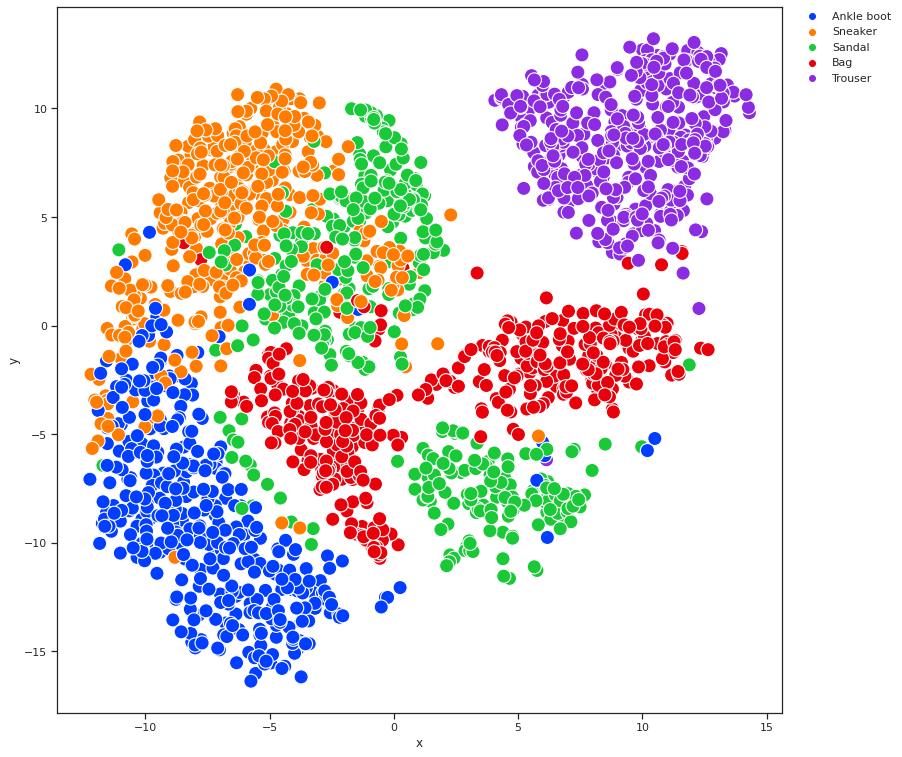

In [34]:
plot_tsne(d2_embs, y_list)

# Classification of the anomalous datapoints into five classes

In [35]:
def show_images_classification(x, y, ncols=10):
    """ plots first ncols images in a batch """
    x = x.view(10, 32, 32)

    fig, ax = plt.subplots(1, ncols, figsize=(20, 2))
    for idx in range(ncols):
        ax[idx].imshow(x[idx].cpu().numpy(), cmap="Greys")
        ax[idx].axis('off')
        ax[idx].set_title(fmnist_classes[y[idx].item()])
    plt.show()

Number of prediction for trouser:  45
Number of prediction for sandal:  7
Number of prediction for sneaker:  5
Number of prediction for bag:  35
Number of prediction for ankle boot:  8


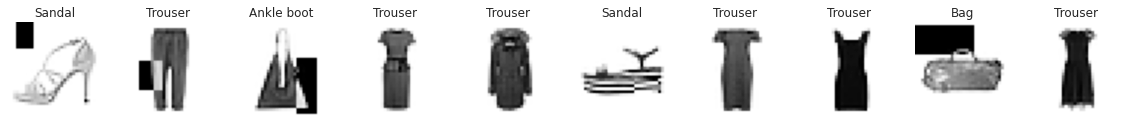

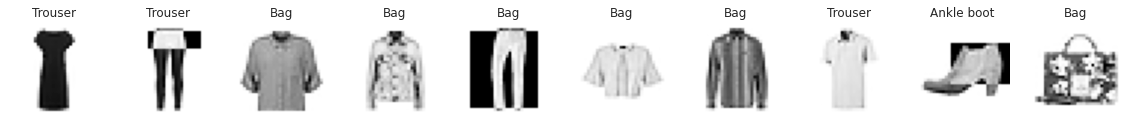

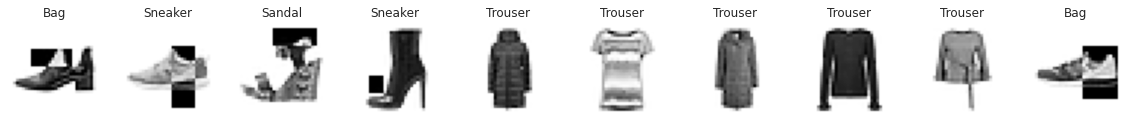

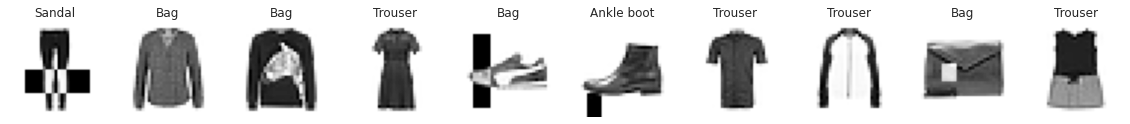

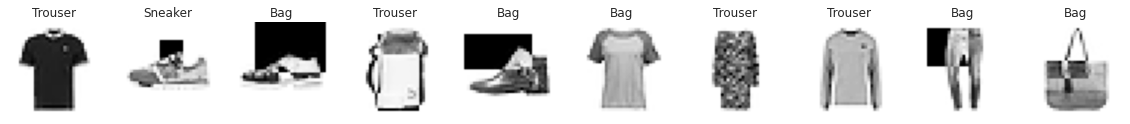

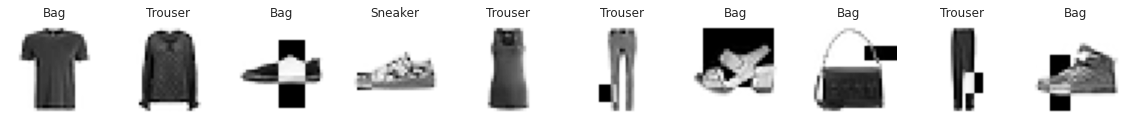

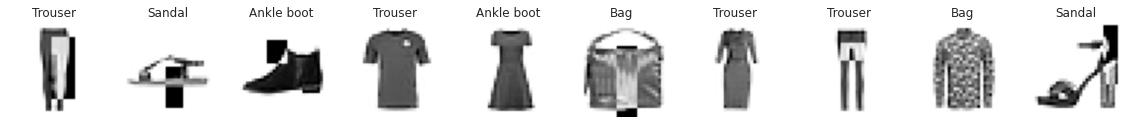

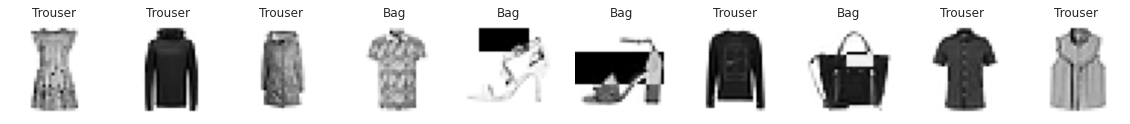

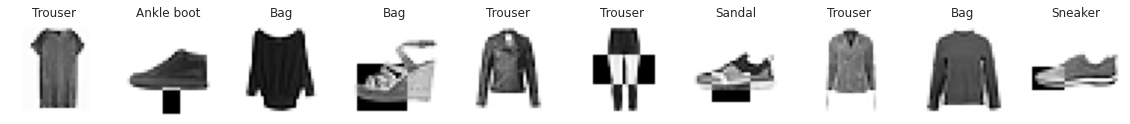

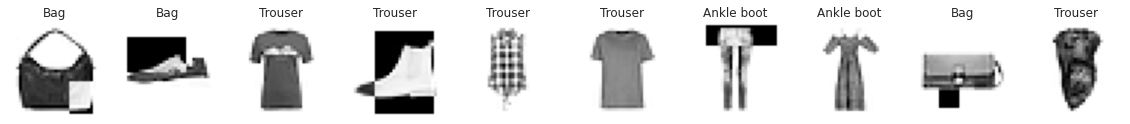

In [36]:
# fmnist_classes = {0:"Trouser", 1:"Sandal", 2:"Sneaker", 3:"Bag", 4:"Ankle boot", 5:"anomaly"}

print("Number of prediction for trouser: ", np.sum(y_pred_anomaly == 0))
print("Number of prediction for sandal: ", np.sum(y_pred_anomaly == 1))
print("Number of prediction for sneaker: ", np.sum(y_pred_anomaly == 2))
print("Number of prediction for bag: ", np.sum(y_pred_anomaly == 3))
print("Number of prediction for ankle boot: ", np.sum(y_pred_anomaly == 4))

for i in range(10):
    show_images_classification(x_anomaly[i*10 : (i*10)+10], y_pred_anomaly[i*10 : (i*10)+10])